In [1]:
%load_ext autoreload

import voxelproj
import numpy as np
import pycuda.driver as cuda
import matplotlib.pyplot as plt

from test_utils import test_single_voxel,print_adjoint_info
from tqdm.auto import trange



In [7]:
SEED = 138294

dtype = "float32"

SX = 6
SY = 6
H = 3
PX = SX+SY
n_angles = 31

y_shape_z0 = (n_angles, PX, H)
y_shape_z2 = (H, n_angles, PX)

x_shape_z0 = (SY, SX, H)
x_shape_z2 = (H, SY, SX)


np.random.seed(SEED)
x2 = np.random.randn(*x_shape_z2).astype(dtype)
y2 = np.random.randn(*y_shape_z2).astype(dtype)
angles = np.linspace(0, np.pi, n_angles, endpoint=False).astype(dtype)


In [9]:
def test_z2():
    print("Testing Z2")

    def A(x):
        return voxelproj.forward_z2(x, angles, y=y_shape_z2)

    def AT(y):
        return voxelproj.backward_z2(y, angles, x=x_shape_z2)

    # x_shape_z2 = (H, SY, SX)
    elements = []
    zi = 1
    for yi in trange(SY):
        for xi in range(SX):
            elements.extend(
                test_single_voxel(
                    x_shape_z2, y_shape_z2, zi, yi, xi, forward=A, backward=AT
                )
            )
    return np.array(elements)
z2_el = test_z2()

Testing Z2


  0%|          | 0/6 [00:00<?, ?it/s]

Text(0.5, 1.0, 'im_vox_z2 1.73e-05')

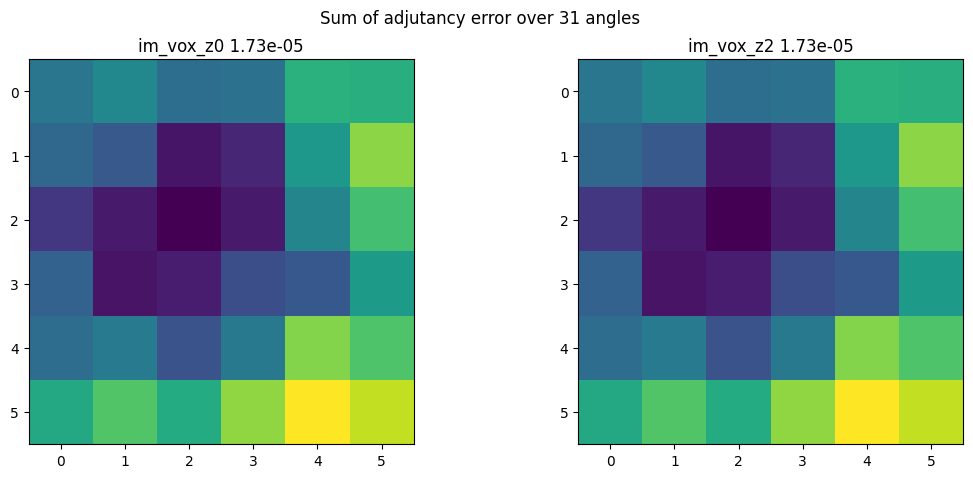

In [10]:
def error_slice(elements, SY, SX):
    retval = np.zeros((SY, SX))
    for el in elements:
        i0, i1, i2, i, j, k, lhs, rhs = el
        retval[int(i1), int(i2)] += abs(lhs - rhs)
    return retval

im_vox_z0 = error_slice(z2_el, SY,SX)
im_vox_z2 = error_slice(z2_el, SY,SX)


f, (ax1,ax2)= plt.subplots(ncols = 2, figsize = (13,5))
ax1.imshow(im_vox_z0)
ax2.imshow(im_vox_z2)

f.suptitle(f'Sum of adjutancy error over {n_angles} angles')
ax1.set_title(f'im_vox_z0 {np.mean(im_vox_z0):.2e}')
ax2.set_title(f'im_vox_z2 {np.mean(im_vox_z0):.2e}')



X info (3, 2, 3) (24, 12, 4)
Y info (67, 8, 3) (96, 12, 4)


Text(0.5, 1.0, 'Sinogram')

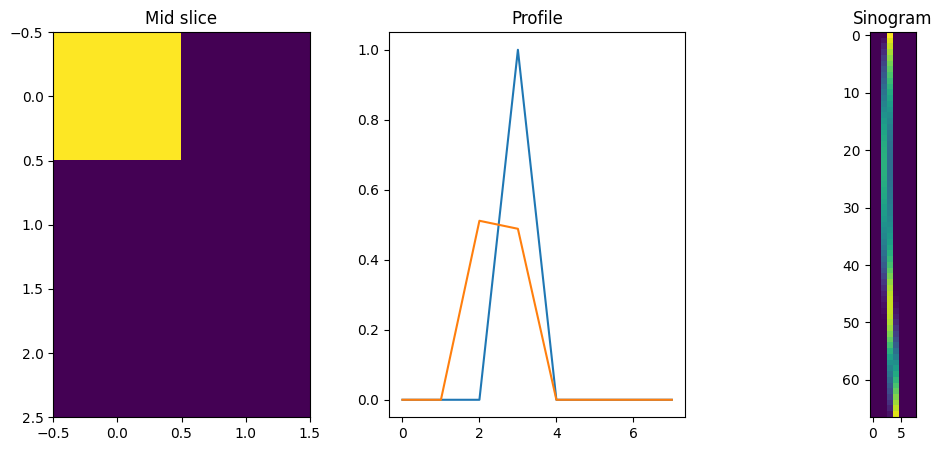

In [54]:
x = x_z0
y = np.zeros((len(angles),projector_width,height),dtype = 'float32')

y = voxelproj.forward_z0(x, angles, y=y)
sum_vox_z0 = np.sum(np.sum(y,-1),-1)


print("X info", x.shape, x.strides)
print("Y info", y.shape, y.strides)
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (13,5))
ax1.imshow(x[:, :, H//2])
ax2.plot(y[0,:,H//2])
ax2.plot(y[n_angles//2,:,H//2])
ax3.imshow(y[:, :, H//2])
ax1.set_title("Mid slice")
ax2.set_title("Profile")
ax3.set_title("Sinogram")



X info (3, 3, 2) (24, 8, 4)
Y info (3, 67, 8) (2144, 32, 4)


Text(0.5, 1.0, 'Sinogram')

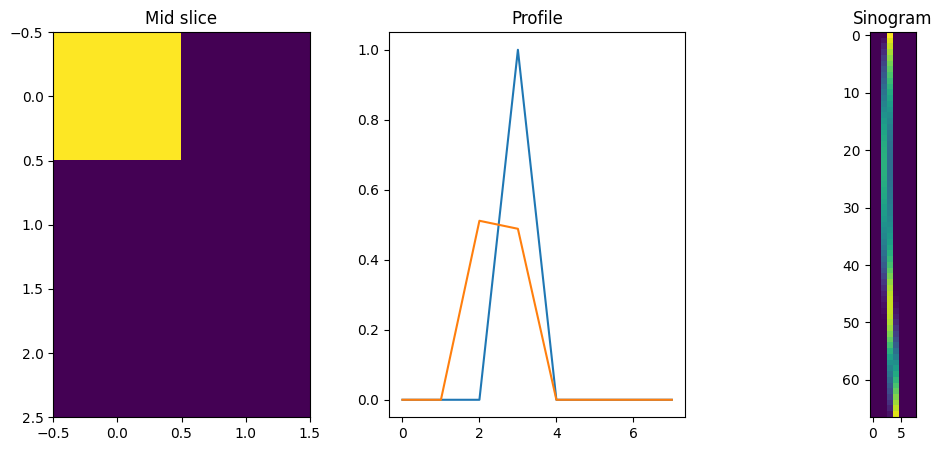

In [55]:
x = x_z2
y = np.zeros((height,len(angles),projector_width),dtype = 'float32')

y = voxelproj.forward_z2(x, angles, y=y)
sum_vox_z2 = np.sum(np.sum(y,-1),0)


print("X info", x.shape, x.strides)
print("Y info", y.shape, y.strides)
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (13,5))
ax1.imshow(x[H//2,:, :])
ax2.plot(y[H//2,0,:])
ax2.plot(y[H//2,n_angles//2,:])
ax3.imshow(y[H//2,:, :])
ax1.set_title("Mid slice")
ax2.set_title("Profile")
ax3.set_title("Sinogram")



(3, 67, 8)
X info (3, 3, 2) (24, 8, 4)
Y info (3, 67, 8) (2144, 32, 4)


Text(0.5, 1.0, 'Sinogram')

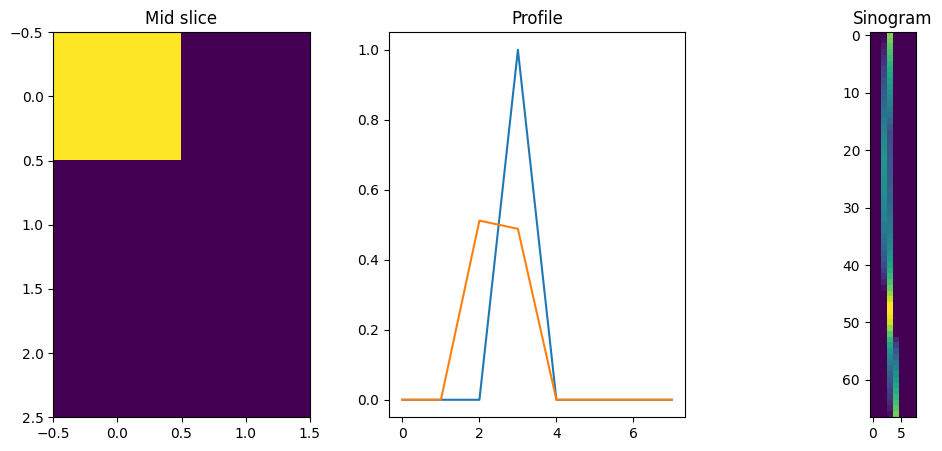

In [56]:
import tomosipo as ts
x = x_z2
vg = ts.volume(shape=x.shape)
pg = ts.parallel(angles=angles, shape=(x.shape[0],projector_width))
A = ts.operator(vg, pg)
y = A(x)
print(y.shape)
sum_ts = np.sum(np.sum(y,-1),0)


print("X info", x.shape, x.strides)
print("Y info", y.shape, y.strides)
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (13,5))
ax1.imshow(x[H//2,:, :])
ax2.plot(y[H//2,0,:])
ax2.plot(y[H//2,n_angles//2,:])
ax3.imshow(y[H//2,:, : ])
ax1.set_title("Mid slice")
ax2.set_title("Profile")
ax3.set_title("Sinogram")


SX=2 SY=3 H=3
X info (3, 3, 2) (24, 8, 4)
Y info (67, 3, 8) (96, 32, 4)


Text(0.5, 1.0, 'Sinogram')

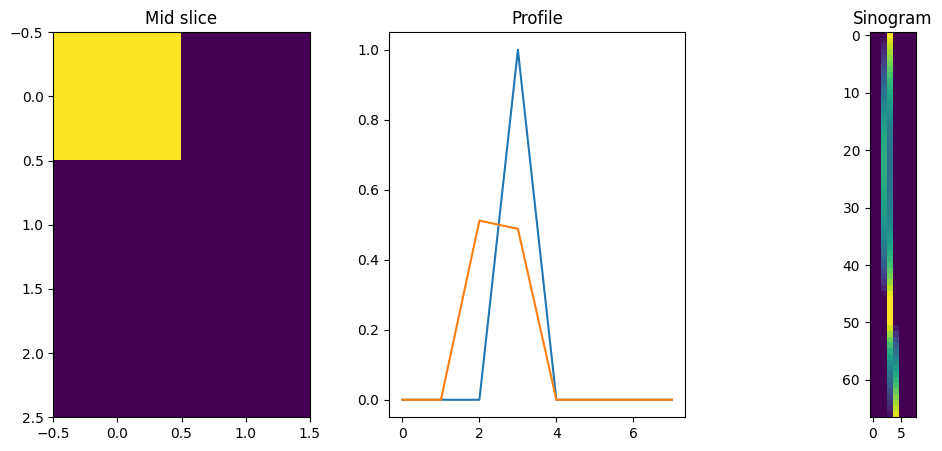

In [57]:
from leapctype import *
leapct = tomographicModels()

angles_deg =  np.degrees(angles)
leapct.set_parallelbeam(
    numAngles=len(angles_deg),
    numRows=height,
    numCols=projector_width,
    pixelHeight=1,
    pixelWidth=1,
    centerRow=0.5 * (height- 1),
    centerCol=0.5 * (projector_width - 1),
    phis=angles_deg,
)
leapct.set_volume(SX,SY,height, voxelWidth=1, voxelHeight=1)
y = np.zeros((len(angles_deg),height,projector_width),dtype = 'float32')
leapct.project(y, x_z2)
sum_leap = np.sum(np.sum(y,-1),-1)

print(f'SX={SX} SY={SY} H={height}')
print("X info", x.shape, x.strides)
print("Y info", y.shape, y.strides)
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (13,5))
ax1.imshow(x[H//2,:, :])
ax2.plot(y[0,H//2,:])
ax2.plot(y[n_angles//2,H//2,:])
ax3.imshow(y[:,H//2, : ])
ax1.set_title("Mid slice")
ax2.set_title("Profile")
ax3.set_title("Sinogram")

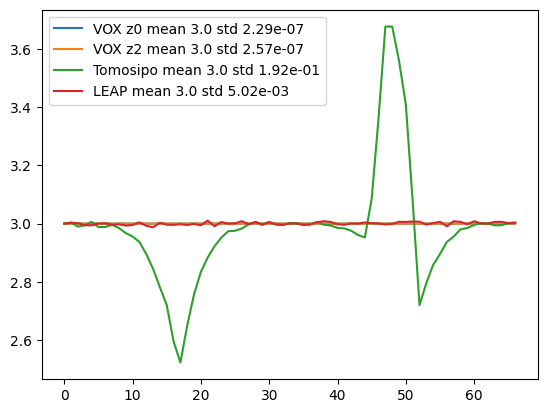

In [58]:
plt.plot(sum_vox_z0, label = f'VOX z0 mean {np.mean(sum_vox_z0):.1f} std {np.std(sum_vox_z0):.2e}')
plt.plot(sum_vox_z2, label = f'VOX z2 mean {np.mean(sum_vox_z2):.1f} std {np.std(sum_vox_z2):.2e}')
plt.plot(sum_ts, label = f'Tomosipo mean {np.mean(sum_ts):.1f} std {np.std(sum_ts):.2e}')
plt.plot(sum_leap, label = f'LEAP mean {np.mean(sum_leap):.1f} std {np.std(sum_leap):.2e}')
plt.legend()